In [1]:
import torch
from DatasetBuilder import DatasetBuilder
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler, StableDiffusionPipeline
import numpy
import imageio

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
diffusion_model_epoch = 58
model_id = "stabilityai/stable-diffusion-2-1-base"
directory = "C:/Users/allan/Downloads/FacesDatasetDepth"
img_size = 512
batch_size = 4
device = torch.device('cuda')

In [3]:
model = torch.load(f"Models/Epoch{diffusion_model_epoch}.pt").to(device)


In [4]:
model_id = "stabilityai/stable-diffusion-2-1-base"
vae = StableDiffusionPipeline.from_pretrained(model_id).to(torch.device(device)).vae
vae.enable_xformers_memory_efficient_attention()
vae_scaling_factor = vae.config.scaling_factor
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\allan\miniconda3\envs\torch\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [5]:
def decode_latents_to_images(latents):
    with torch.no_grad():
        latents = latents / vae_scaling_factor
        decoded_images = vae.decode(latents.detach()).sample
        images = torch.permute(decoded_images, (0, 2, 3, 1))
        images = images.to('cpu')
        images = numpy.asarray(images)
        images = images*0.5+0.5
        images = images*255
        images = numpy.asarray(images, numpy.uint8)
        pass
    return images

In [6]:
def get_relevant_frames_all_images(num_images, latent_size = 64, device = torch.device('cuda')):
    relevant_frames = []
    #Create noisy latents
    latents = torch.randn(num_images, 4, latent_size, latent_size).to(device=device)
    #Denoise the latents
    for step, t in enumerate(noise_scheduler.timesteps):
        with torch.no_grad():
            #Get noise prediction
            noise_preds = model(latents, t).sample
            pass
        #Using noise pred and the image at the timestep t, calculate the previous sample
        latents = noise_scheduler.step(noise_preds, t, latents).prev_sample
        if (((step+1) <800 and (step+1)%20 == 0) or ((step+1)>=800 and (step+1)%5 == 0)):
            #Decode the latents
            decoded_images = decode_latents_to_images(latents)
            relevant_frames.append(decoded_images)
            pass
        pass
    #Show the final frames
    last_frame = relevant_frames[-1]
    for i in range(last_frame.shape[0]):
        plt.imshow(last_frame[i])
        plt.show()
        pass
    return relevant_frames

In [7]:
def get_relevant_frames_of_one_image(frames, index):
    relevant_frames = []
    for step, image in enumerate(frames):
        image = image[index]
        relevant_frames.append(image)
        pass
    return relevant_frames

In [8]:
def save_gifs(frames, num_images):
    for i in range(num_images):
        relevant_frames = get_relevant_frames_of_one_image(frames, i)
        #print(len(relevant_frames))
        # Create the GIF using imageio
        with imageio.get_writer(f'DenoisingGiFs/diffusionGif{i}.gif', mode='I') as writer:
            for image in relevant_frames:
                writer.append_data(image)
                pass
            pass
        pass
    pass

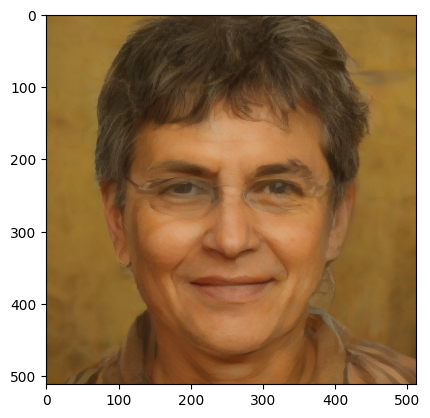

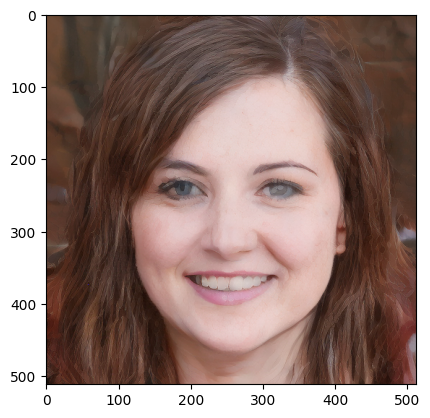

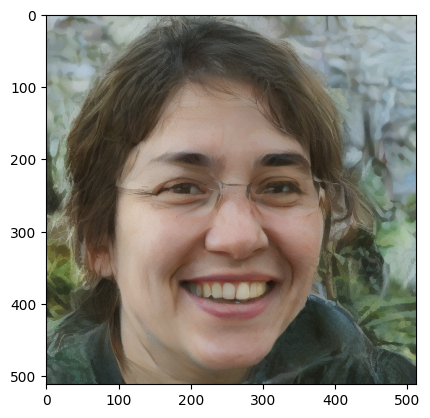

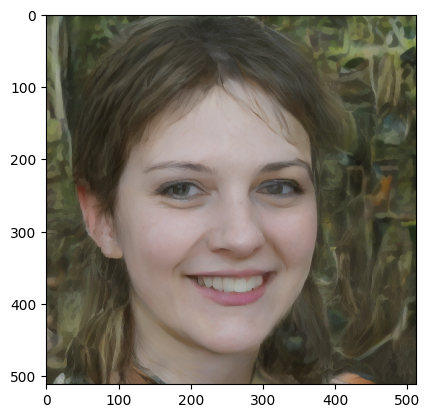

In [9]:
num_images = 4
relevant_frames = get_relevant_frames_all_images(num_images=num_images)

In [ ]:
save_gifs(frames=relevant_frames, num_images=num_images)

![GiF](DenoisingGiFs/diffusionGif0.gif)

![GiF](DenoisingGiFs/diffusionGif1.gif)

![GiF](DenoisingGiFs/diffusionGif2.gif)

![GiF](DenoisingGiFs/diffusionGif3.gif)